In [1]:
import pandas as pd
import numpy as np
import patsy
import warnings
import statsmodels.api as sm
import copy
from scipy.stats import norm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.simplefilter('ignore')
np.random.seed(1234)

In [14]:
# set up double lasso library
#! pip install multiprocess
#! git clone https://github.com/maxhuppertz/hdmpy.git
import sys
sys.path.insert(1, "./hdmpy")

# We wrap the package so that it has the familiar sklearn API
import hdmpy
from sklearn.base import BaseEstimator


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

### Assignment 1: Causal Analysis of College Degree Attainment on Wages

In [21]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)
y = np.log(data["wage"]).values
Z = data.drop(["wage", "lwage"], axis=1)

X_baseline_full = patsy.dmatrix(
    "clg + sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2)",
    data,
    return_type="dataframe"
)

# a.) partialling out predictive effect of clg
X_baseline = X_baseline_full.drop(columns="Intercept")

final_baseline_model = sm.OLS(y, sm.add_constant(X_baseline)).fit(cov_type='HC1')
ci_baseline = final_baseline_model.conf_int()
ape_baseline = final_baseline_model.params["clg"]

print(f"Coefficient (predictive clg effect) in OLS without interactions: {ape_baseline:.4f}")
print(f"95% CI: [{float(ci_baseline.loc["clg", 0]):.4f}, {float(ci_baseline.loc["clg", 1]):.4f}]")

X_interactions_full = patsy.dmatrix(
    "clg + (sex + mw + so + we + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2",
    data,
    return_type="dataframe"
)
X_interactions = X_interactions_full.drop(columns="Intercept")

final_interactions_model = sm.OLS(y, sm.add_constant(X_interactions)).fit(cov_type='HC1')

ape_interactions = final_interactions_model.params["clg"]
ci_interactions = final_interactions_model.conf_int()
print(f"Coefficient (predictive clg effect) in OLS with interactions: {ape_interactions:.4f}")
print(f"95% CI: [{float(ci_interactions.loc["clg", 0]):.4f}, {float(ci_interactions.loc["clg", 1]):.4f}]")

# # a.) same with double lasso regression
X_interactions_no_clg = X_interactions_full.drop(columns="clg")
X_interactions_no_clg = X_interactions_no_clg - X_interactions_no_clg.mean()
clg = data["clg"].values
lasso_first = lasso_model()
lasso_first.fit(sm.add_constant(X_interactions_no_clg), clg)
d_hat_lasso = lasso_first.predict(sm.add_constant(X_interactions_no_clg))
d_hat_lasso = clg - d_hat_lasso
lasso_second = lasso_model()
lasso_second.fit(sm.add_constant(X_interactions_no_clg), y)
y_hat_lasso = lasso_second.predict(sm.add_constant(X_interactions_no_clg))
y_hat_lasso = y - y_hat_lasso

final_lasso_model = sm.OLS(y_hat_lasso, d_hat_lasso).fit(cov_type='HC1')
ape_lasso = final_lasso_model.params[0]
ci_lasso = final_lasso_model.conf_int()

print(f"Coefficient (predictive clg effect) in double lasso with interactions: {ape_lasso:.4f}")
print(f"95% CI: [{float(ci_lasso[0, 0]):.4f}, {float(ci_lasso[0, 1]):.4f}]")

Coefficient (predictive clg effect) in OLS without interactions: 0.1329
95% CI: [0.1007, 0.1650]
Coefficient (predictive clg effect) in OLS with interactions: 0.1152
95% CI: [0.0796, 0.1508]
Coefficient (predictive clg effect) in double lasso with interactions: 0.1436
95% CI: [0.1120, 0.1752]


In [42]:
# b.) 
from  sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Filter dataset and define outcome and regressor
remove_columns = ['lwage', 'wage', 'shs', 'hsg', 'scl', 'ad']
y = data['lwage']
Z = data.drop(columns=remove_columns)

# Construct all our control variables
Zcontrols = patsy.dmatrix('0 + (sex + mw + so + we + ne + exp1 + exp2 + exp3 + exp4 + C(occ2) + C(ind2))**2', data=Z, return_type='dataframe')
Zcontrols = Zcontrols - Zcontrols.mean(axis=0)

# Construct all the variables that we will use to model heterogeneity of effect in a linear manner
Zhet = patsy.dmatrix('0 +  (sex + mw + so + we + exp1 + exp2 + exp3 + exp4)', data=Z, return_type='dataframe')
Zhet = Zhet - Zhet.mean(axis=0)

# Construct all interaction variables between clg and heterogeneity variables
Zhet['clg'] = Z['clg']
Zinteract = patsy.dmatrix('0 + clg + clg * (sex + mw + so + we + exp1 + exp2 + exp3 + exp4)', data=Zhet, return_type='dataframe')
interaction_cols = [col for col in Zinteract.columns if col.startswith('clg')]

X_all_interactions = pd.concat([Zcontrols, Zinteract], axis=1)

scaled_data = StandardScaler().fit_transform(X_all_interactions)
X_all_interactions = pd.DataFrame(scaled_data, columns=X_all_interactions.columns, index=X_all_interactions.index)

clg_all_interactions = X_all_interactions["clg"].copy()
X_all_interactions_no_clg = X_all_interactions.drop(columns="clg")
clg_interaction_cols = [col for col in X_all_interactions.columns if "clg" in col]

linreg = LinearRegression().fit(X_all_interactions, y)

alphas_lasso = np.logspace(-3, 2, 20)
lasso_cv = LassoCV(cv=5, alphas=alphas_lasso, random_state=0)
lasso_cv.fit(sm.add_constant(X_all_interactions), y)

rlasso_model = lasso_model().fit(sm.add_constant(X_all_interactions), y)

alphas_enet = np.logspace(-3, 2, 20)
enet_model = ElasticNetCV(cv=5, alphas=alphas_enet, l1_ratio=[0.5], random_state=0)
enet_model.fit(sm.add_constant(X_all_interactions), y)
enet_coefs = pd.Series(enet_model.coef_, index=sm.add_constant(X_all_interactions).columns)

alphas_ridge = np.logspace(-3, 2, 20)
ridge_model = RidgeCV(alphas=alphas_ridge, cv=5)
ridge_model.fit(sm.add_constant(X_all_interactions), y)
ridge_coefs = pd.Series(ridge_model.coef_, index=sm.add_constant(X_all_interactions).columns)

ols_coefs = pd.Series(linreg.coef_, index=X_all_interactions.columns)
lasso_cv_coefs = pd.Series(lasso_cv.coef_, index=sm.add_constant(X_all_interactions).columns)
rlasso_coefs = pd.Series(rlasso_model.rlasso_.est["beta"].loc[clg_interaction_cols, 0])

print("=== OLS Coefficients for clg Interactions ===")
print(ols_coefs[clg_interaction_cols])

print("\n=== LassoCV Coefficients for clg Interactions ===")
print(lasso_cv_coefs[clg_interaction_cols])

print("\n=== Rlasso Coefficients for clg Interactions ===")
print(rlasso_coefs[clg_interaction_cols])

print("\n=== ElasticNetCV Coefficients for clg Interactions ===")
print(enet_coefs[clg_interaction_cols])

print("\n=== RidgeCV Coefficients for clg Interactions ===")
print(ridge_coefs[clg_interaction_cols])

=== OLS Coefficients for clg Interactions ===
clg         0.054647
clg:sex     0.005063
clg:mw      0.004432
clg:so     -0.003571
clg:we     -0.014854
clg:exp1    0.379806
clg:exp2   -1.272032
clg:exp3    1.602543
clg:exp4   -0.687151
dtype: float64

=== LassoCV Coefficients for clg Interactions ===
clg         0.060202
clg:sex    -0.000000
clg:mw      0.001865
clg:so      0.000000
clg:we     -0.003994
clg:exp1    0.000000
clg:exp2    0.000000
clg:exp3   -0.000000
clg:exp4   -0.000000
dtype: float64

=== Rlasso Coefficients for clg Interactions ===
clg         0.059029
clg:sex     0.000000
clg:mw      0.000000
clg:so      0.000000
clg:we      0.000000
clg:exp1    0.000000
clg:exp2    0.000000
clg:exp3    0.000000
clg:exp4    0.000000
Name: 0, dtype: float64

=== ElasticNetCV Coefficients for clg Interactions ===
clg         0.060058
clg:sex    -0.000000
clg:mw      0.002325
clg:so      0.000000
clg:we     -0.005074
clg:exp1    0.000635
clg:exp2    0.000000
clg:exp3   -0.000000
clg:exp4

1. Ordinary Least Squares (OLS) Coefficients:  
  
clg         0.054647  
clg:sex     0.005063  
clg:mw      0.004432  
clg:so     -0.003571  
clg:we     -0.014854  
clg:exp1    0.379806  
clg:exp2   -1.272032  
clg:exp3    1.602543  
clg:exp4   -0.687151  
  
Inductive Bias:  
OLS imposes no penalty on coefficients. It simply picks parameter estimates to minimize the residual sum of squares (subject to the constraints, if any).  

Effect:  
All coefficients can freely vary, which often leads to a lack of sparsity. None are forced to zero unless the data themselves perfectly identify a coefficient as zero (which is rare).
Some coefficients can become relatively large in magnitude. Indeed, we see a strong negative coefficient for clg:exp2 in OLS, which gets heavily shrunk in other methods.  
  
2. LassoCV Coefficients:  

clg         0.060202  
clg:sex    -0.000000  
clg:mw      0.001865  
clg:so      0.000000  
clg:we     -0.003994  
clg:exp1    0.000000  
clg:exp2    0.000000  
clg:exp3   -0.000000  
clg:exp4   -0.000000    
 
Several coefficients have been driven exactly to zero, such as clg:so, and all the clg:exp terms.  

Inductive Bias:  
Lasso (L1 penalty) encourages sparsity (coefficients to be exactly zero) by penalizing the absolute size of the coefficients.
In cross-validation, the model picks an alpha (regularization strength) that balances fit versus sparsity.  
  
Effect:  
Some interaction terms are set to exactly zero, implying that the model found them less important in explaining the outcome once the regularization and cross-validation were taken into account.  
  
3. Rlasso Coefficients:  

clg         0.059029  
clg:sex     0.000000  
clg:mw      0.000000  
clg:so      0.000000  
clg:we      0.000000  
clg:exp1    0.000000  
clg:exp2    0.000000  
clg:exp3    0.000000  
clg:exp4    0.000000   
 
This is even more sparse than the LassoCV result. Only clg and remains non-zero.  
  
Inductive Bias:  
  
Rlasso (as implemented in the hdm package in R or similar theoretical constructions in Python) uses a theoretically derived penalty that accounts for sample size and other factors. It is designed to do strong variable selection under high-dimensional setups or when one wants rigorous post-selection inference.  
  
Effect:  
An even higher degree of sparsity is typical, because the method is quite strict in testing which variables remain in the model. In the example, it leaves only the main clg term as non-zero.
Coefficients can differ from standard LassoCV because the penalty and selection procedure are computed differently.  
  
4. ElasticNetCV Coefficients:  
  
clg         0.060058  
clg:sex    -0.000000  
clg:mw      0.002325  
clg:so      0.000000  
clg:we     -0.005074  
clg:exp1    0.000635  
clg:exp2    0.000000  
clg:exp3   -0.000000  
clg:exp4   -0.000000    
  
Similar to LassoCV in that some coefficients go exactly to zero, though a few more remain non-zero. For example, clg:exp2 is tiny (not zero) rather than exactly zero.  
  
Inductive Bias:  
  
ElasticNet (combination of L1 and L2 penalties) tries to achieve a balance between:  
The sparsity effect from L1 (like Lasso).  
The shrinkage effect from L2 (like Ridge).  
  
Effect:  
Some coefficients remain zero (like clg:sex and clg:so), suggesting that the L1 component is strong enough for those to drop out.  
Other coefficients (e.g. clg:exp1) are only partially shrunk instead of being dropped entirely, indicating the interplay of L1 and L2 penalty often keeps small but non-zero coefficients rather than fully eliminating them.  
  
5. RidgeCV Coefficients:  
  
clg         0.058272  
clg:sex     0.003466  
clg:mw      0.010956  
clg:so      0.002155  
clg:we     -0.013270  
clg:exp1    0.020974  
clg:exp2   -0.004445  
clg:exp3   -0.007034  
clg:exp4   -0.003460  
  
No coefficients are set to zero; some are “shrunk” compared to OLS.    
  
Inductive Bias:  
  
Ridge (L2 penalty) penalizes the squared magnitude of coefficients. This shrinks unimportant coefficients towards zero but never sets any coefficient exactly to zero.  
  
Effect:  
All interaction terms remain in the model, although each is typically smaller in absolute value compared to OLS (especially if the unpenalized OLS estimate was large).
The penalty encourages distributing the effect among more predictors rather than dropping them.

In [47]:
# c.) Same with double lasso
double_lasso_coefficients = {}
dl_resids = {}
res_d_hat = {}
res_y_hat = {}
alpha = {}
for term in clg_interaction_cols:
    X_all_interactions_temp = copy.deepcopy(X_all_interactions)
    X_all_interactions_temp = X_all_interactions_temp.drop(columns=term)
    lasso_first = lasso_model()
    lasso_first.fit(sm.add_constant(X_all_interactions_temp), X_all_interactions[term])
    d_hat_lasso = lasso_first.predict(sm.add_constant(X_all_interactions_temp))
    d_hat_lasso = X_all_interactions[term] - d_hat_lasso
    res_d_hat[term] = d_hat_lasso
    lasso_second = lasso_model()
    lasso_second.fit(sm.add_constant(X_all_interactions_temp), y)
    y_hat_lasso = lasso_second.predict(sm.add_constant(X_all_interactions_temp))
    y_hat_lasso = y - y_hat_lasso
    res_y_hat[term] = y_hat_lasso
    final_lasso_model = sm.OLS(y_hat_lasso, d_hat_lasso).fit(cov_type='HC1')
    double_lasso_coefficients[term] = final_lasso_model.params[0]
    dl_resids[term] = final_lasso_model.resid
    alpha[term] = [final_lasso_model.params[0]]
print("\n=== Double Lasso Coefficients for clg Interactions ===")
print(pd.Series(double_lasso_coefficients))


=== Double Lasso Coefficients for clg Interactions ===
clg         0.067861
clg:sex    -0.000879
clg:mw      0.012274
clg:so      0.001352
clg:we     -0.012643
clg:exp1    0.057857
clg:exp2    0.107209
clg:exp3   -0.100789
clg:exp4   -0.201923
dtype: float64


The coefficients are different to the ones we see in lassoCV. There is no exact zeroing out of coefficients. The coefficient on clg is slightly larger. Interestingly, the coefficient on clg:exp4, which is largest in magnitude in double lasso, is zerod out by lassoCV. 

 clg         0.067861  
clg:sex    -0.000879  
clg:mw      0.012274  
clg:so      0.001352  
clg:we     -0.012643  
clg:exp1    0.057857  
clg:exp2    0.107209  
clg:exp3   -0.100789  
clg:exp4   -0.201923  

In [48]:
# d.) joint confidence intervals
V = np.zeros((len(clg_interaction_cols), len(clg_interaction_cols)))
for it, c in enumerate(clg_interaction_cols):
    Jc = np.mean(res_d_hat[c]**2)
    for itp, cp in enumerate(clg_interaction_cols):
        Jcp = np.mean(res_d_hat[cp]**2)
        Sigma = np.mean(res_d_hat[c] *dl_resids[c] *dl_resids[cp] *res_d_hat[cp])
        V[it, itp] = Sigma / (Jc * Jcp)
print(f"Diagonal of V: {np.diag(V)}")

n = X_all_interactions.shape[0]
for it, c in enumerate(clg_interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]
print(alpha)
# put all in a dataframe
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

# Calculate and pointwise p-value
summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['Std. Error'] = df['stderr']
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']
summary['ci_upper'] = df['point'] + 1.96 * df['stderr']

Drootinv = np.diagflat(1 / np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv
np.random.seed(123)
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 95)

summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary["CI individual lower"] = df['point'] - 1.96 * df['stderr']
summary["CI individual upper"] = df['point'] + 1.96 * df['stderr']
summary['CI joint lower'] = df['point'] - c * df['stderr']
summary['CI joint upper'] = df['point'] + c * df['stderr']
summary



Diagonal of V: [2.99393462e-01 3.83623923e-01 5.80510025e-01 5.78985637e-01
 5.33062386e-01 1.11869029e+01 8.81719197e+01 3.81370988e+02
 2.41498312e+01]
{'clg': [np.float64(0.06786067895456221), np.float64(0.007624608366753301)], 'clg:sex': [np.float64(-0.000879293936598336), np.float64(0.008630763707512786)], 'clg:mw': [np.float64(0.012273643504042031), np.float64(0.010616986070025041)], 'clg:so': [np.float64(0.0013520975772504384), np.float64(0.010603037093760256)], 'clg:we': [np.float64(-0.01264281192839891), np.float64(0.010173851748544717)], 'clg:exp1': [np.float64(0.057856765951483494), np.float64(0.04660701840201933)], 'clg:exp2': [np.float64(0.10720864442652436), np.float64(0.13084632629113768)], 'clg:exp3': [np.float64(-0.10078925361718138), np.float64(0.27212610882579574)], 'clg:exp4': [np.float64(-0.2019231832934456), np.float64(0.06847837327467242)]}


,Estimate,CI individual lower,CI individual upper,CI joint lower,CI joint upper
clg,0.067861,0.052916,0.082805,0.046970,0.088751
clg:sex,-0.000879,-0.017796,0.016037,-0.024526,0.022768
clg:mw,0.012274,-0.008536,0.033083,-0.016815,0.041363
clg:so,0.001352,-0.019430,0.022134,-0.027699,0.030403
clg:we,-0.012643,-0.032584,0.007298,-0.040518,0.015232
clg:exp1,0.057857,-0.033493,0.149207,-0.069840,0.185553
clg:exp2,0.107209,-0.149250,0.363667,-0.251291,0.465708
clg:exp3,-0.100789,-0.634156,0.432578,-0.846375,0.644796
clg:exp4,-0.201923,-0.336141,-0.067706,-0.389544,-0.014303


### Assignment 2

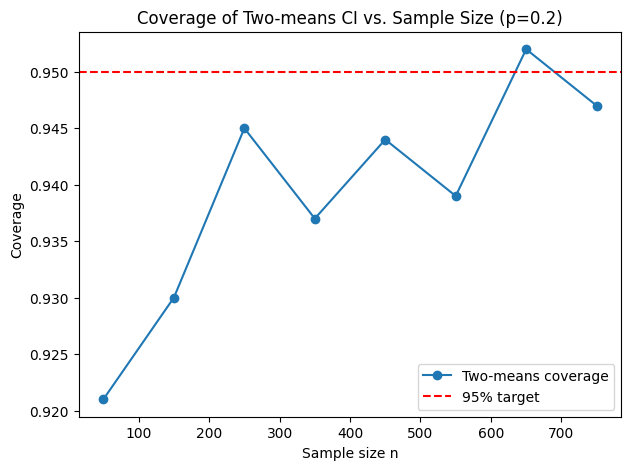

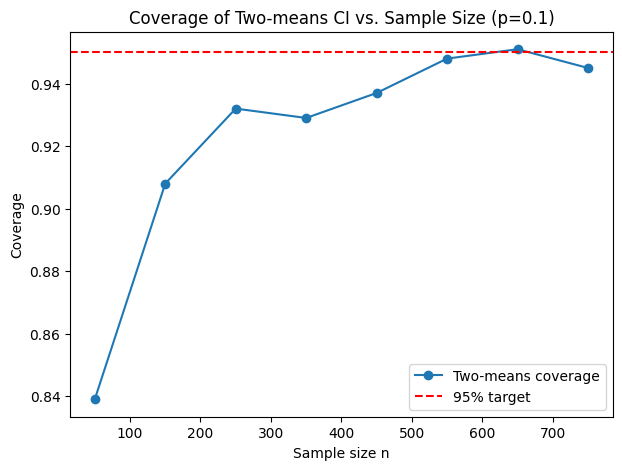

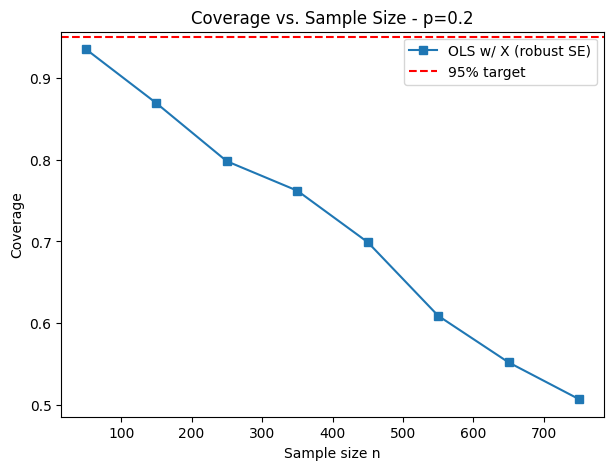

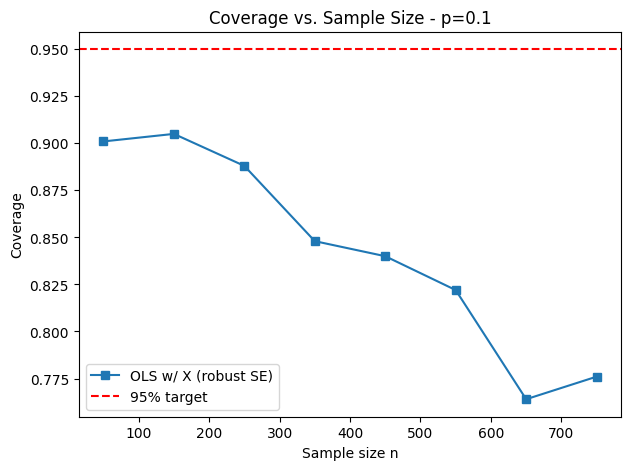

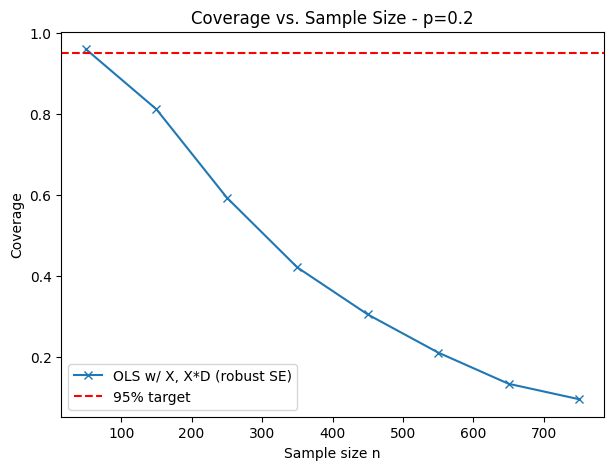

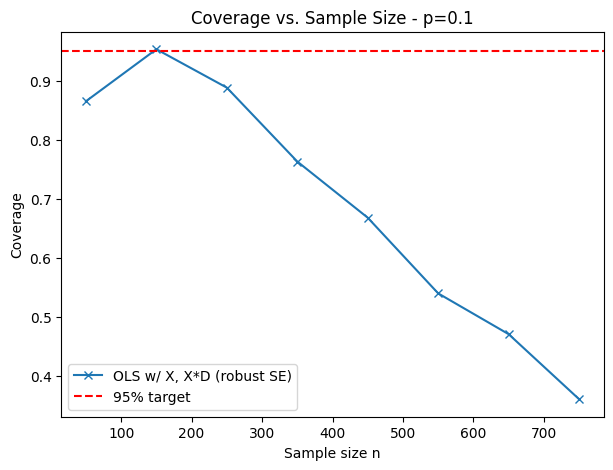

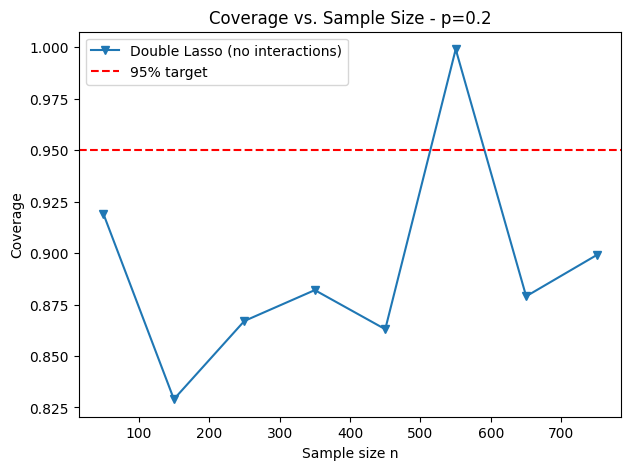

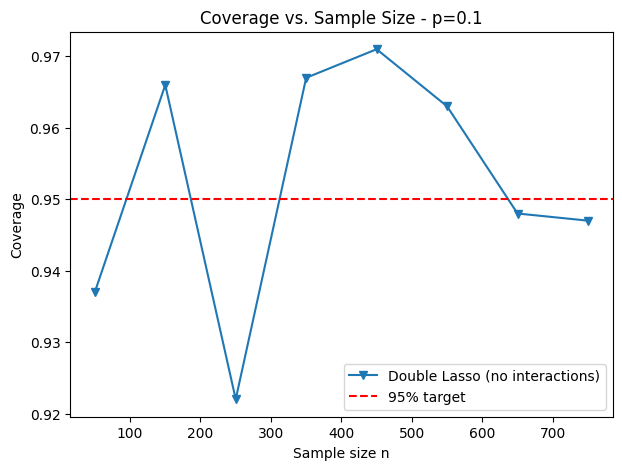

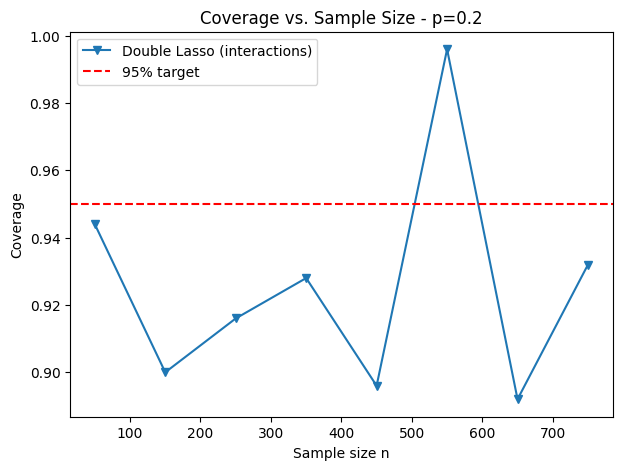

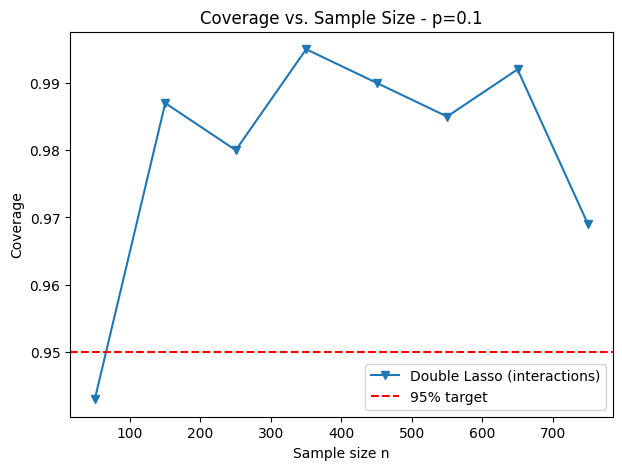

In [59]:
from sklearn.linear_model import LinearRegression

def gen_data(n, d, p, delta, base):
    """
    n: sample size
    d: number of covariates
    p: probability of treatment
    delta: true treatment effect
    base: baseline response
    
    Returns:
        y (n-vector): outcome
        D (n-vector): treatment indicator
        X (n x d): covariates
    """
    D = np.random.binomial(1, p, size=n)
    X = np.random.normal(0, 1, size=(n, d))
    
    # Potential outcomes:
    #  Y(0) = base - X[:,0] + noise
    #  Y(1) = delta + base + X[:,0] + noise
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=n)
    y1 = delta + base + X[:, 0] + np.random.normal(0, 1, size=n)
    
    # Observed outcome:
    y = D * y1 + (1 - D) * y0
    return y, D, X

n_grid = [50, 150, 250, 350, 450, 550, 650, 750]
reps = 1000
delta_true = 1.0      # given
d = 10                # dimensionality of X
base = 0.3            # baseline


def two_means_estimate(y, D):
    """
    Returns (estimate, se) for the two-means difference in y between treated and untreated.
    """
    treat_mask = (D == 1)
    control_mask = (D == 0)
    
    n1 = treat_mask.sum()
    n0 = control_mask.sum()
    
    y1_bar = np.mean(y[treat_mask])
    y0_bar = np.mean(y[control_mask])
    tau_hat = y1_bar - y0_bar
    
    # sample variances
    V1 = np.var(y[treat_mask]) / np.mean(D)
    V0 = np.var(y[control_mask]) / np.mean(1-D)
    
    # standard error
    se = np.sqrt((V1+V0) / (n1+n0))
    return tau_hat, se


def run_two_means_estimate(p):

    coverage_results_2means = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat, se = two_means_estimate(y, D)
            # 95% CI:
            ci_lower = tau_hat - 1.96 * se
            ci_upper = tau_hat + 1.96 * se
            
            # Check coverage:
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1

        coverage = covered_count / reps
        coverage_results_2means.append(coverage)

    # Plot coverage:
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_2means, marker='o', label='Two-means coverage')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage of Two-means CI vs. Sample Size (p={p})')
    plt.legend()
    plt.show()

run_two_means_estimate(0.2)
run_two_means_estimate(0.1)


def ols_with_covariates(y, D, X):
    X = X - X.mean(axis=0)
    W = np.column_stack([D, X])
    reg = sm.OLS(y,W).fit(cov_type='HC3')
    tau_hat = reg.params[0]
    tau_se = reg.HC3_se[0]
    return tau_hat, tau_se

def run_ols_with_covariates(p):
    coverage_results_ols = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat, tau_se = ols_with_covariates(y, D, X)
            
            ci_lower = tau_hat - 1.96 * tau_se
            ci_upper = tau_hat + 1.96 * tau_se
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_ols = covered_count / reps
        coverage_results_ols.append(coverage_ols)

    # Plot coverage
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_ols, marker='s', label='OLS w/ X (robust SE)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_ols_with_covariates(0.2)
run_ols_with_covariates(0.1)


def ols_with_interactions(y, D, X):
    X = X - X.mean(axis=0)
    DX = D.reshape(-1,1) * X
    W = np.column_stack([D, X, DX])
    reg = sm.OLS(y, W).fit(cov_type='HC3')
    tau_hat = reg.params[0]
    tau_se = reg.HC3_se[0]
    return tau_hat, tau_se


def run_ols_with_interactions(p):
    coverage_results_ols_inter = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            tau_hat, tau_se = ols_with_interactions(y, D, X)
            
            ci_lower = tau_hat - 1.96 * tau_se
            ci_upper = tau_hat + 1.96 * tau_se
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_ols_inter.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_ols_inter, marker='x', label='OLS w/ X, X*D (robust SE)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()

run_ols_with_interactions(0.2)
run_ols_with_interactions(0.1)

def run_double_lasso_no_interactions(p):
    coverage_results_dl = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            X = X - X.mean(axis=0)  # demean covariates
            X_design = np.column_stack([D, X])
            
            lasso_first = lasso_model()
            lasso_first.fit(X_design, D)
            D_hat = lasso_first.predict(X_design)
            D_resid = D - D_hat
            
            lasso_second = lasso_model()
            lasso_second.fit(X_design, y)
            y_hat = lasso_second.predict(X_design)
            y_resid = y - y_hat
            
            final_model = sm.OLS(y_resid, D_resid).fit(cov_type='HC3')
            tau_hat = final_model.params[0]
            ci_lower = tau_hat - 1.96 * final_model.bse[0]
            ci_upper = tau_hat + 1.96 * final_model.bse[0]
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_dl.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_dl, marker='v', label='Double Lasso (no interactions)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_double_lasso_no_interactions(0.2)
run_double_lasso_no_interactions(0.1)


def run_double_lasso_with_interactions(p):
    coverage_results_dl_inter = []

    for n in n_grid:
        covered_count = 0
        for _ in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            X = X - X.mean(axis=0)  # demean covariates
            X_design = patsy.dmatrix("D + X + D*X", {"D": D, "X": X})
            
            lasso_first = lasso_model()
            lasso_first.fit(X_design, D)
            D_hat = lasso_first.predict(X_design)
            D_resid = D - D_hat
            
            lasso_second = lasso_model()
            lasso_second.fit(X_design, y)
            y_hat = lasso_second.predict(X_design)
            y_resid = y - y_hat
            
            final_model = sm.OLS(y_resid, D_resid).fit(cov_type='HC3')
            tau_hat = final_model.params[0]
            ci_lower = tau_hat - 1.96 * final_model.bse[0]
            ci_upper = tau_hat + 1.96 * final_model.bse[0]
            
            if (delta_true >= ci_lower) and (delta_true <= ci_upper):
                covered_count += 1
        
        coverage_results_dl_inter.append(covered_count / reps)
        
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_dl_inter, marker='v', label='Double Lasso (interactions)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% target')
    plt.xlabel('Sample size n')
    plt.ylabel('Coverage')
    plt.title(f'Coverage vs. Sample Size - p={p}')
    plt.legend()
    plt.show()
    
run_double_lasso_with_interactions(0.2)
run_double_lasso_with_interactions(0.1)

a.) For all experiments, we are targeting the coverage to be 95%, since we are calculating a 95% confidence interval.  
  
For the simple two-means estimate at p=0.2, the coverage reaches the desired level at a sample size of 150.  
For the two-means estimate at p=0.1, the threshold is reached at a sample size of 450.  

Based on this, the recommendation I would give to a fellow student, would be to have a sample size of at least that size respectively
  
When we lower the probability to 0.1, the number of samples required for the two-means estimate to reach the desired coverage increases. This is because the variance of the estimate increases as the probability decreases, which requires more samples to reduce the variance.  
  
b.) When using OLS with de-meaned covariates to estimate the treatment effect, the coverage is close to the desired value initially, but lowers as the sample size increases. 

For p = 0.1, it is in the right ballpark up to sample sizes of 150, for p = 0.2, the coverage decreases after sample size 50.

When using OLS with de-meaned covariates plus interactions to estimate the teatment effect, the desired coverage is reached only at 50 samples for p=0.2, and 150 samlpes for p=0.1 before decaying rapidly.  

c.) The double lasso is the most robust method in terms of coverage. It reaches the desired coverage at 50 samples for p=0.2 and 50 samples for p=0.1, and remains stable at that level as the sample size increases for both probabilities and with linear, as well as interactive covariates.